In [26]:
#!pip install transformers

In [27]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/talos-1/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/talos-1/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/talos-1/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/talos-1/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/talos-1/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/talos-1/nltk_data...
[nltk_data]    |   Package movie_reviews is already

True

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
# import warnings
from nltk.corpus import wordnet
import random
from sklearn.neural_network import MLPClassifier
# import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [29]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

### Function Definitions

In [30]:
#Generator Function for Non-Numeric Words
#X is a pandas Series of a sentence
#here gamma is the number of iterations
#returns a series of modified messages (might be modified)


#Function takes a sequence or word and produces a modified version.
# If the dataset has less unique works than half it's set, it randomly resamples.
# Otherwise:
  #It splits the sentence into words.
  #Identifies adjectives using WordNet (lexical db of semantic relations between words).
  #Chooses a word in the sentence (prefers adjectives) and looks up the antonym.
  #If there is an antonym, it replaces the word with one of them, using gamma.
  #Otherwise is leaves the sentence unchanged.

#Note: Lemmatisation works by reducing a word to it's base form.
# Meaning "running", "ran", and "runs" are all lemmatised to "run".

def generatorWords(X,gamma):
  fakeX = []

  if len(X.unique()) < len(X)/2: #if the number of unique values is less than half of the set
    uniqueVals = X.unique()
    fakeX = []
    for _ in range(len(X)):
      fakeX.append(random.choice(uniqueVals))
  else:
    for _, value in X.items(): 
      words = value.split(" ")
      adjs = []
      choosenWord = ""
      pos_all = dict()
      antonyms = []

      #priortize adjectives
      for w in words:
        #print(w)
        pos_l = set()
        for tmp in wordnet.synsets(w): #alias 'wn' not aliased.
            if tmp.name().split('.')[0] == w:
                pos_l.add(tmp.pos())
        pos_all[w] = pos_l

      #in the list of word classes we single out the adjectives
      for a in pos_all:  
        if "a" in pos_all[a]:
          adjs.append(a)
      
      #here we choose which word to flip
      if adjs: 
        choosenWord = adjs[0] #adjs[0] if len(adjs) > 1 else adjs[0]
      else:
        choosenWord = words[0] #words[0] if len(words) > 1 else words[0]

      #find antonyms of the choosen word
      for syn in wordnet.synsets(choosenWord):
        for lm in syn.lemmas():
            if lm.antonyms():
                antonyms.append(lm.antonyms()[0].name())
      if antonyms:
        new = [antonyms[gamma] if x==choosenWord else x for x in words]
      else:
        new = words
        # new = [x for x in words if x == choosenWord] #[x if x == choosenWord else x for x in words]
      fakeX.append(" ".join(new))
  return pd.Series(fakeX)


In [31]:
#Generator Function For Numeric Data Points
#X is a series of numbers
#gamma = 1.4
#intX = list(map(int, X)) #make sure X is an int
def generatorNum(X,gamma):
  xHat = np.mean(X)
  sx = np.std(X)
  randomUpper = (xHat) + (sx * gamma)
  randomLower = (xHat) - (sx * gamma)
  beta = []
  for _ in range(int(len(X))):
      beta.append(random.randrange(int(randomLower),int(randomUpper)))
  beta = list(map(str, beta))
  #print(beta)
  return pd.Series(beta)

In [32]:
#Generator That Points Data Into The Right Generator
def generator(df, gamma):
  mDF = df.copy()
  mDF["temperature"] = generatorNum(df["temperature"],gamma)
  mDF["outlook"] = generatorWords(df["outlook"],0)
  mDF["wind"] = generatorWords(df["wind"],0)
  mDF["humidity"] = generatorNum(df["humidity"],gamma)
  fakeData = addLabel(makeSentence(mDF),1) #column 0 is sentences, column 1 is label
  realData = addLabel(makeSentence(df),0)  #Label 0 means data, label 1 means fake data
  return(pd.concat([fakeData,realData],axis=0),fakeData)

In [33]:
#Merges All DataFrame Columns Into A Single Sentence
#Returns a series of the merged DataFrame columns
def makeSentence(df):
  #df is a data frame
  df = df.copy().map(str)
  seriesA = df[df.columns[0:]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
  return seriesA

In [34]:
#Adds a label columns to series for classification
#Returns dataframe of two columns, the series and the labels
def addLabel(series,label):
  #takes in a pandas series and a label
  #returns a dataframe
  labels = []
  [labels.append(label) for _ in range(len(series))]
  labels = pd.Series(labels)
  return pd.concat([series,labels],axis=1)

In [ ]:
#Discriminiator for deteremining whether data is malicious or not
#Returns new gamma, other parameters are for testing and graphing purposes
def discriminator(X, gamma, rho):
  #takes in dataframe in BERT format of sentence and label
  #returns a new gamme to generate data with
  score,indexes,fn,total = BERT(X)
  print("score: " + str(score))
  #if 0.35 < score < 0.55:
  ##  return None
  #else:
  return (score,gamma + rho,indexes,fn,total)

In [36]:
def BERT(df):
  #df is a dataframe containing sentences and labels
  #BERT returns a accuracy and indexes of false negatives

  #tokenize
  tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) #pad
  attention_mask = np.where(padded != 0, 1, 0)                            #apply masks
  input_ids = torch.tensor(padded)  
  attention_mask = torch.tensor(attention_mask)                           #put masks through torch tensor

  #run through bert
  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)
  features = last_hidden_states[0][:,0,:].numpy()
  labels = df[1]
  
  return(regression(features,labels))

In [37]:
#Takes BERT pretrained output and put's it through logistic regression
#Returns accuracy and indexes of false negatives
def regression(features,labels):
  train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
  #lr_clf = LogisticRegression(max_iter=500)
  #lr_clf.fit(train_features, train_labels)
  #return(lr_clf.score(test_features, test_labels))
  NeuralNetwork = MLPClassifier(solver='adam', activation="logistic", random_state=1,max_iter=5000)
  NeuralNetwork.fit(train_features, train_labels)
  y2 = NeuralNetwork.predict(test_features)
  y2 = pd.Series(NeuralNetwork.predict(test_features))
  #print(test_labels)
  i=0
  indexes = []
  for index, value in test_labels.items(): 
    if value == 1:
      if y2[i] == 0:
        indexes.append(index)
    i+=1
  #print(indexes)
  tn, fp, fn, tp = confusion_matrix(test_labels, y2).ravel()
  #fp = confusion_matrix(test_labels, y2)[0][1]
  total = len(test_labels)
  return (NeuralNetwork.score(test_features,test_labels),indexes,fn,total)

In [38]:
def indexToEntry(X,indexes):
  #finds list of indexes in X and returns a dataframe with the entries
  entries = []
  for i in indexes:
    entries.append(X.iloc[i])
  return(pd.DataFrame(entries))

In [39]:
# def logisticRegression(train_features, test_features, train_labels, test_labels):
#   lr_clf = LogisticRegression(max_iter=500)
#   lr_clf.fit(train_features, train_labels)
#   #print(lr_clf.score(test_features, test_labels))
#   y_pred = lr_clf.predict(test_features)
#   score = lr_clf.score(test_features, test_labels)
#   tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
#   return(fn,score)

In [40]:
#TODO
def logisticRegression(train_features, test_features, train_labels, test_labels):
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix

    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            solver="lbfgs",
            max_iter=5000,
            C=0.5,
            penalty="l2",
            n_jobs=-1,
            random_state=0
        )
    )

    clf.fit(train_features, train_labels)
    y_pred = clf.predict(test_features)
    score = clf.score(test_features, test_labels)
    tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
    return (fn, score)


In [41]:
def RandomForest(train_features, test_features, train_labels, test_labels):
  RandForest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
  RandForest.fit(train_features, train_labels)
  forest_pred = RandForest.predict(test_features)
  score = RandForest.score(test_features,test_labels)
  tn, fp, fn, tp = confusion_matrix(test_labels, forest_pred).ravel()
  return(fn,score)


In [42]:
def KNN(train_features, test_features, train_labels, test_labels):
  #K Nearest Neighbor With Optimal Neighbor (1)
  knn = KNeighborsClassifier(n_neighbors = 1)
  knn.fit(train_features,train_labels)
  score = knn.score(test_features, test_labels)
  y_pred = knn.predict(test_features)
  tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
  #print(confusion_matrix(test_labels, y_pred))
  #print(classification_report(y_test, y_pred))
  return(fn,score)

In [43]:
def MLP(train_features, test_features, train_labels, test_labels):
  NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
  NeuralNetwork.fit(train_features, train_labels)
  nn_pred = NeuralNetwork.predict(test_features)
  score = NeuralNetwork.score(test_features,test_labels)
  #print(confusion_matrix(test_labels, nn_pred))
  tn, fp, fn, tp = confusion_matrix(test_labels, nn_pred).ravel()
  return(fn,score)

In [44]:
def SVM(train_features, test_features, train_labels, test_labels):
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  clf.fit(train_features,train_labels)
  svmPred = clf.predict(test_features)
  score = clf.score(test_features,test_labels)
  #print(confusion_matrix(test_labels, pred))
  tn, fp, fn, tp = confusion_matrix(test_labels, svmPred).ravel()
  return(fn,score)

In [45]:
def tests(df, mDF):
  ogData = addLabel(makeSentence(df),0)
  testData = pd.concat([ogData,mDF])
  # tokenized = testData[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  train_features, test_features, train_labels, test_labels = train_test_split(padded, testData[1], random_state=42)
  lrFN,lrScore = logisticRegression(train_features, test_features, train_labels, test_labels)
  rfFN,rfScore = RandomForest(train_features, test_features, train_labels, test_labels)
  knnFN,knnScore = KNN(train_features, test_features, train_labels, test_labels)
  mlpFN,mlpScore = MLP(train_features, test_features, train_labels, test_labels)
  svmFN,svmScore = SVM(train_features, test_features, train_labels, test_labels)
  #print("test_labels: " + str(len(test_labels)))
  return(lrFN,lrScore,rfFN,rfScore,knnFN,knnScore,mlpFN,mlpScore,svmFN,svmScore)

## Processing

In [46]:
# df = pd.read_csv('https://raw.githubusercontent.com/HenryCWong/adversarialBERTMessages/master/weather_sample_data.csv', delimiter=',')
df = pd.read_csv('weather_sample_data.csv')

In [47]:
# df.drop("Unnamed: 0", axis=1, inplace=True) #unsafe copy
df = df.drop("Unnamed: 0", axis=1)

In [48]:
df.sample(5)

,temperature,outlook,wind,humidity
240,57,sunny,W,74
46,56,partly cloudy,W,17
87,53,partly cloudy,W,39
297,55,thunderstorm,NE,1
140,47,rain,S,15


## Actual Stuffs

In [49]:
X, mDF = generator(df, 1)

In [50]:
display(mDF)

,0,1
0,"54,severe_thunderstorm,SE,25",1
1,"54,cloudy,S,47",1
2,"55,thunderstorm,W,35",1
3,"49,cloudy,NE,62",1
4,"51,rain,S,23",1
...,...,...
495,"51,rain,SE,23",1
496,"48,rain,SW,50",1
497,"44,severe_thunderstorm,SE,64",1
498,"44,thunderstorm,S,62",1


In [51]:
tests(df, mDF) #logistic regression, random forest, knn, mlp, svm

NameError: name 'tokenized' is not defined

In [27]:
score,gamma,indexes,jp,total = discriminator(X, 1, 1)

score: 0.74


In [28]:
print(jp)
print(total)

21
250


In [29]:
malDF = indexToEntry(X,indexes)

In [30]:
malDF.head()

,0,1
411,"44,sunny,S,68",1
136,"55,cloudy,W,24",1
174,"43,sunny,SW,35",1
235,"43,rain,SE,60",1
198,"49,severe_thunderstorm,SW,41",1


In [31]:
gamma = 1
rho = .1
sets = []
scores = []
fns = []
totals = []
gammas = []
lrFNs = []
rfFNs = []
knnFNs = []
mlpFNs = []
svmFNs = []
lrScores = []
rfScores = []
knnScores = []
mlpScores = []
svmScores = []
j = 0
while j < 30:
  X,mDF = generator(df, gamma)
  #print(gamma)
  score,gamma, indexes,fn,total = discriminator(X,gamma,rho)
  scores.append((j,score))
  #malDF = pd.concat([malDF,indexToEntry(X,indexes)])
  lrFN,lrScore,rfFN,rfScore,knnFN,knnScore,mlpFN,mlpScore,svmFN,svmScore = tests(df,mDF)
  #lists for stats
  lrFNs.append(lrFN)
  rfFNs.append(rfFN)
  knnFNs.append(knnFN)
  mlpFNs.append(mlpFN)
  svmFNs.append(svmFN)
  lrScores.append(lrScore)
  rfScores.append(rfScore)
  knnScores.append(knnScore)
  mlpScores.append(mlpScore)
  svmScores.append(svmScore)
  sets.append(indexToEntry(X,indexes))
  fns.append(fn)
  totals.append(total)
  gammas.append(gamma)
  j+=1


score: 0.748


/home/talos-1/miniconda3/envs/adver_bert/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 4 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


score: 0.684
score: 0.636
score: 0.616
score: 0.612
score: 0.58
score: 0.516
score: 0.492
score: 0.528
score: 0.564
score: 0.56
score: 0.564
score: 0.58
score: 0.656
score: 0.648
score: 0.712
score: 0.696
score: 0.648
score: 0.748
score: 0.704
score: 0.748
score: 0.74
score: 0.764
score: 0.76
score: 0.792
score: 0.788
score: 0.796
score: 0.748
score: 0.872
score: 0.84


In [32]:
sortedScores = sorted(scores, key=lambda tup: tup[1])

In [33]:
index,score = sortedScores[0]
malDF = sets[index]
for i in range(1,7):
  index, score = sortedScores[i]
  malDF = pd.concat([malDF,sets[index]])

In [34]:
malDF

,0,1
76,"48,severe_thunderstorm,S,1",1
210,"58,rain,SE,6",1
235,"55,thunderstorm,N,21",1
346,"56,severe_thunderstorm,SE,14",1
139,"43,thunderstorm,NE,75",1
...,...,...
49,"47,cloudy,SE,8",1
350,"44,thunderstorm,N,61",1
481,"45,severe_thunderstorm,W,54",1
333,"40,sunny,SE,7",1


In [35]:
df["temperature"].std()

np.float64(6.261462434898679)

In [36]:
#malDF = pd.concat([malData,addLabel(makeSentence(df),0)])

## Graphing

In [37]:
print(gammas)
print(fns)
print(totals)
print(scores)

[1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000004, 1.5000000000000004, 1.6000000000000005, 1.7000000000000006, 1.8000000000000007, 1.9000000000000008, 2.000000000000001, 2.100000000000001, 2.200000000000001, 2.300000000000001, 2.4000000000000012, 2.5000000000000013, 2.6000000000000014, 2.7000000000000015, 2.8000000000000016, 2.9000000000000017, 3.0000000000000018, 3.100000000000002, 3.200000000000002, 3.300000000000002, 3.400000000000002, 3.500000000000002, 3.6000000000000023, 3.7000000000000024, 3.8000000000000025, 3.9000000000000026, 4.000000000000003]
[np.int64(13), np.int64(22), np.int64(33), np.int64(28), np.int64(22), np.int64(45), np.int64(52), np.int64(50), np.int64(79), np.int64(39), np.int64(48), np.int64(53), np.int64(58), np.int64(59), np.int64(33), np.int64(46), np.int64(56), np.int64(35), np.int64(30), np.int64(42), np.int64(47), np.int64(37), np.int64(40), np.int64(33), np.int64(37), np.int64(34), np.int64(31), np.int64(41), np.int64(26), np.int64(20)]
[25

In [38]:
for a in scores:
  print(a[1])

0.748
0.684
0.636
0.616
0.612
0.58
0.516
0.492
0.528
0.564
0.56
0.564
0.58
0.656
0.648
0.712
0.696
0.648
0.748
0.704
0.748
0.74
0.764
0.76
0.792
0.788
0.796
0.748
0.872
0.84


In [39]:
numScores = []
# [numScores.append(a[1]) for a in scores]
numScores = [s for (_, s) in scores]
print(numScores)

[0.748, 0.684, 0.636, 0.616, 0.612, 0.58, 0.516, 0.492, 0.528, 0.564, 0.56, 0.564, 0.58, 0.656, 0.648, 0.712, 0.696, 0.648, 0.748, 0.704, 0.748, 0.74, 0.764, 0.76, 0.792, 0.788, 0.796, 0.748, 0.872, 0.84]


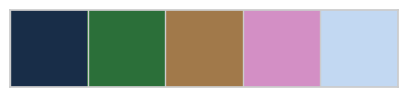

In [40]:
sns.set_style("whitegrid")
sns.palplot(sns.color_palette("cubehelix", 5))
sns.set_palette("cubehelix",5)

<Axes: xlabel='Gamma', ylabel='Accuracy'>

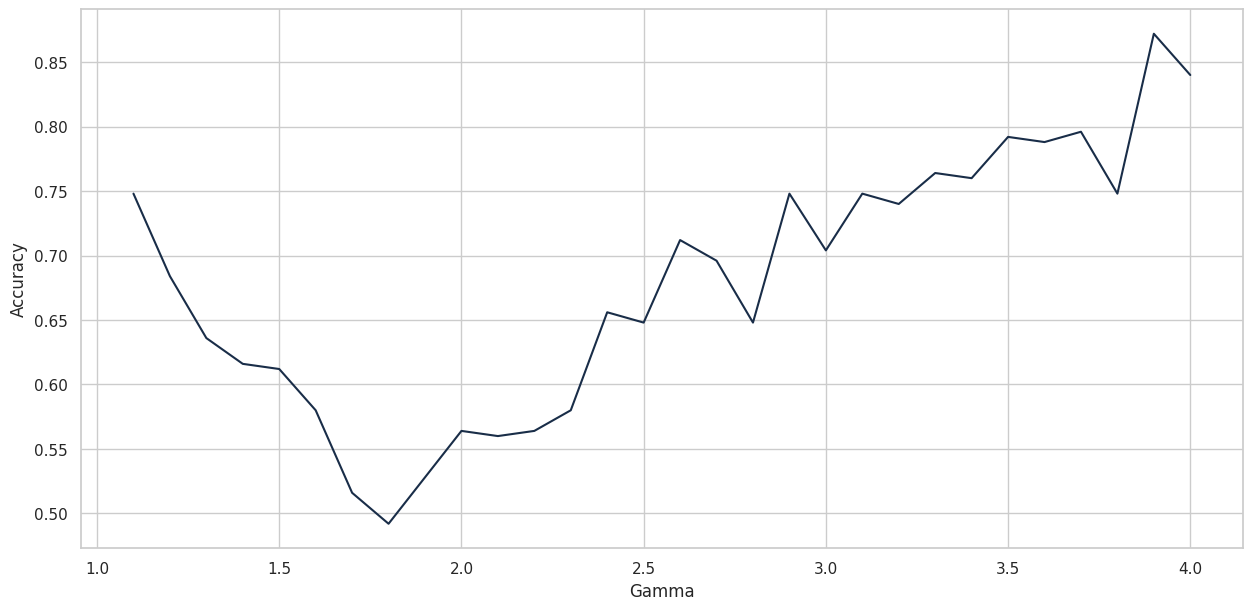

In [41]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set(xlabel='Gamma', ylabel='Accuracy')
sns.lineplot(ax=ax,x=gammas,y=numScores)
#ax = sns.lineplot(x=gammas, y=numScores)


<Axes: xlabel='Gamma', ylabel='Number of False Negatives'>

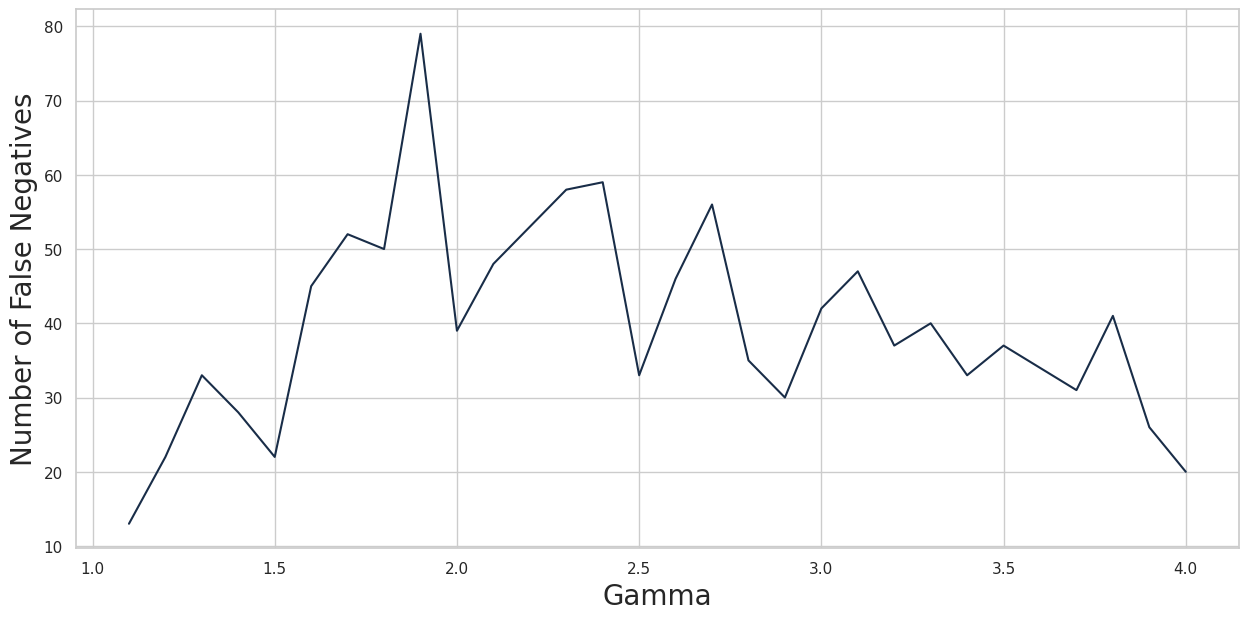

In [42]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Number of False Negatives',fontsize=20);
#ax.set(xlabel='Gamma', ylabel='False Positives')
sns.lineplot(ax=ax,x=gammas,y=fns,markers=True)
#ax = sns.lineplot(x=gammas, y=numScores)


In [43]:
fpRatio = []
for i in range(len(fns)):
  fpRatio.append(fns[i]/totals[i])

<Axes: xlabel='Gamma', ylabel='False Negatives / Total Data Points'>

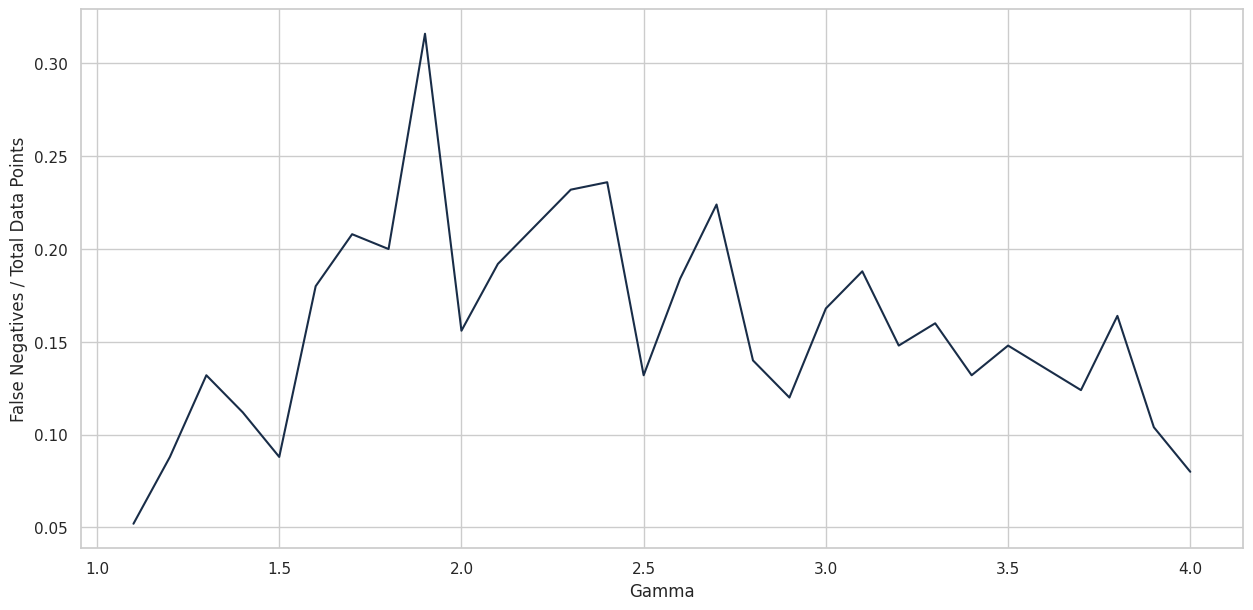

In [44]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set(xlabel='Gamma', ylabel='False Negatives / Total Data Points')
sns.lineplot(ax=ax,x=gammas,y=fpRatio)


In [45]:
d = {"gamma":gammas,"score":numScores,"fn":fns}
nDF = pd.DataFrame(data=d)

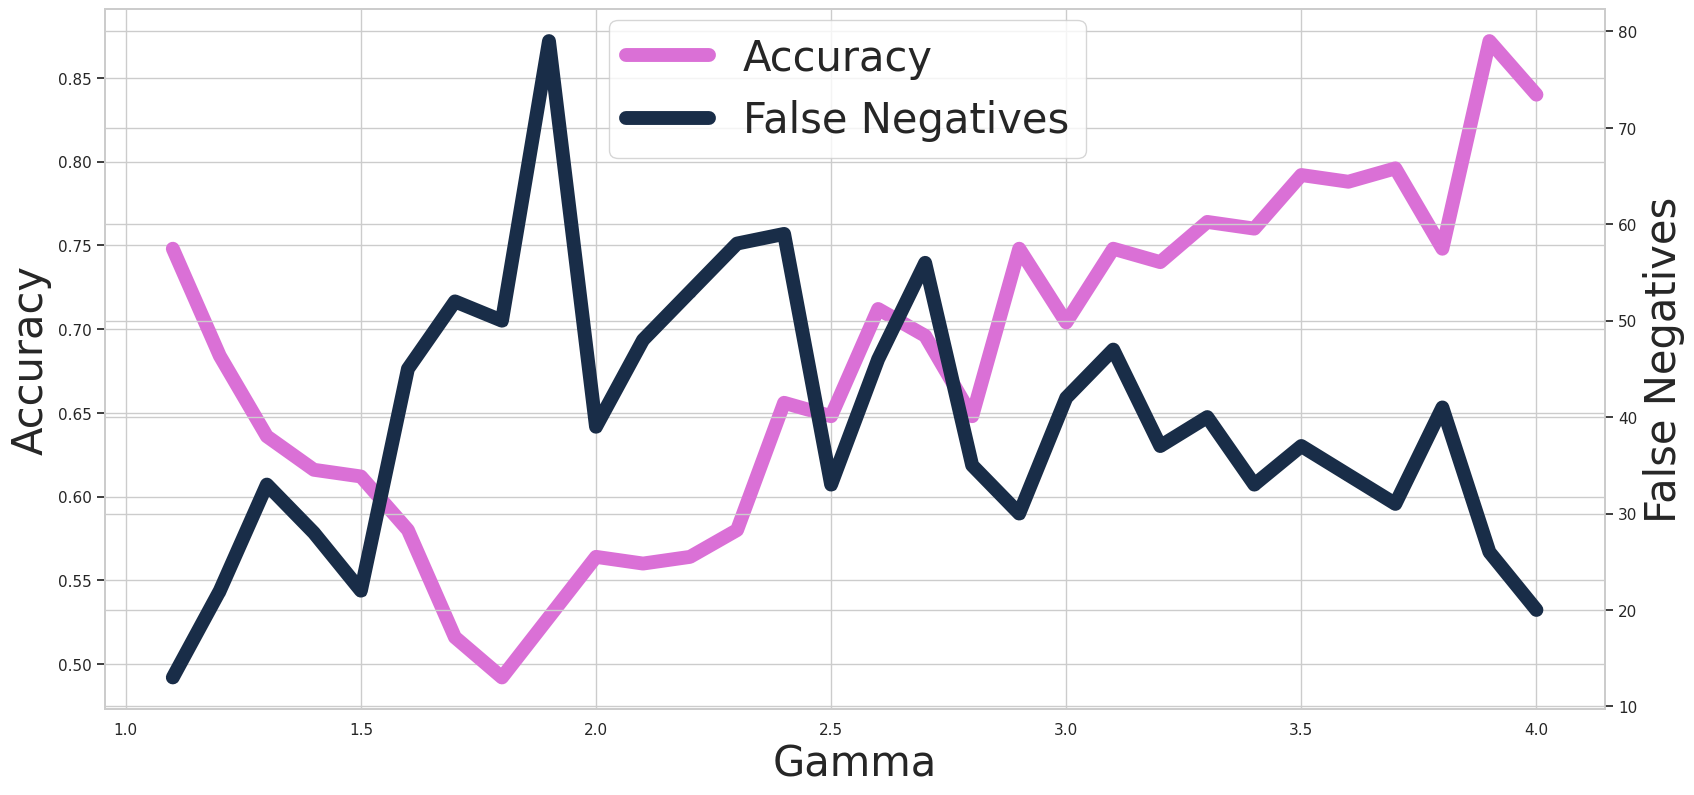

In [46]:
a4_dims = (15, 7)

fig = plt.figure(figsize=a4_dims)
a1 = fig.add_axes([0,0,1,1])
a1.plot(nDF["gamma"],nDF["score"],color="orchid",marker="x",linewidth=10.0)
a1.set_ylabel('Accuracy',fontsize = 30)
a1.set_xlabel("Gamma",fontsize = 30)
a2 = a1.twinx()
a2.plot(nDF["gamma"],nDF["fn"],marker="s",linewidth=10.0)
a2.set_ylabel('False Negatives',fontsize = 30)
a2.set_xlabel("Gamma",fontsize = 30)
fig.legend(labels = ('Accuracy','False Negatives'),loc='upper center',prop={'size': 30})
plt.show()

In [47]:
#Iterpolation attempt
from scipy.interpolate import interp1d

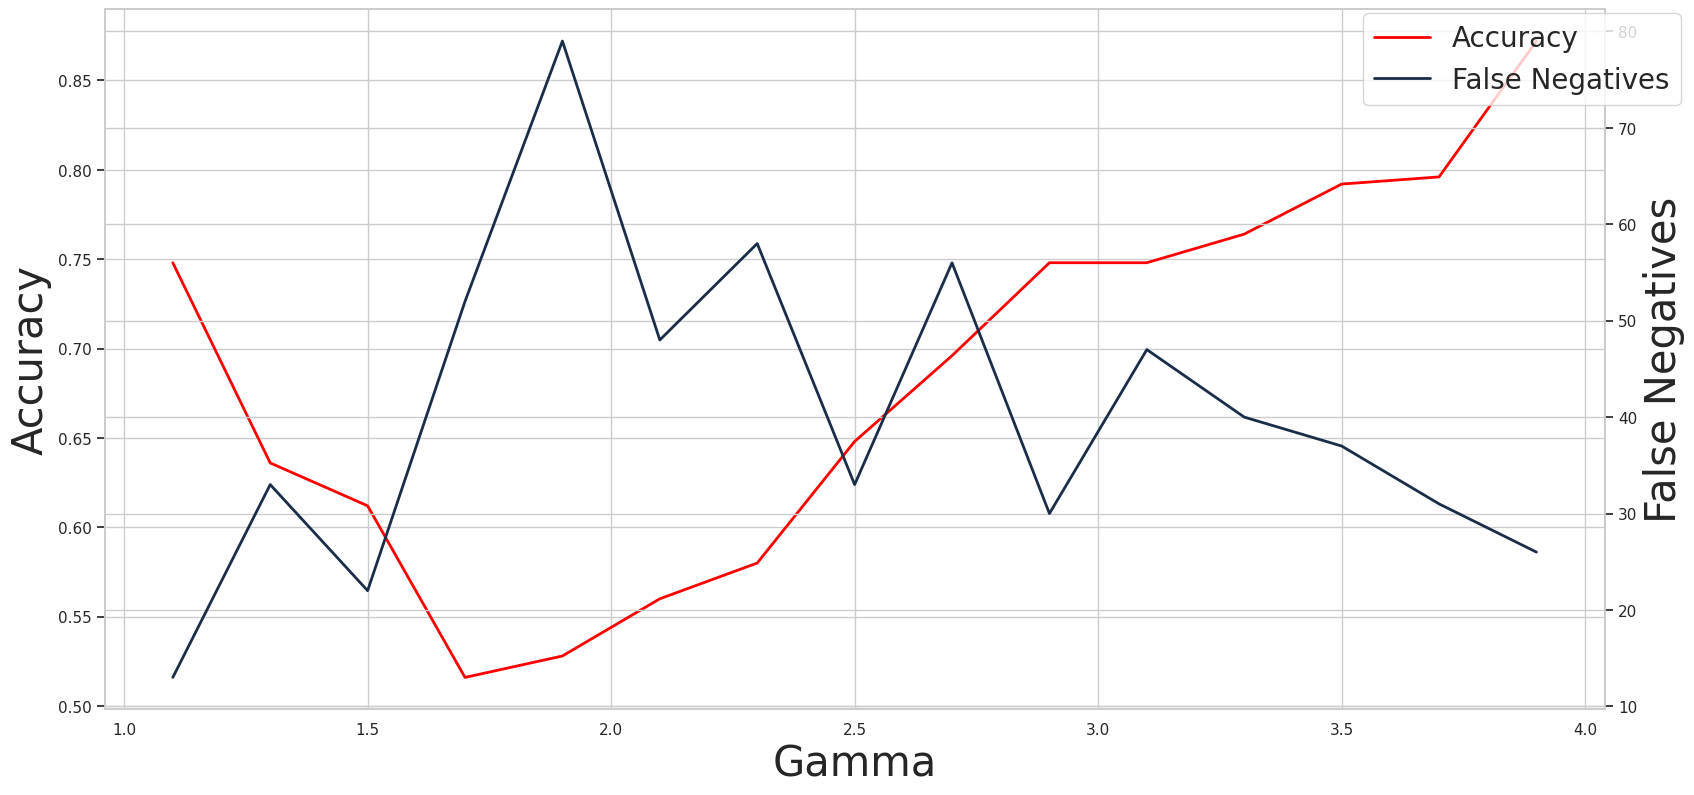

In [48]:
f1 = interp1d(nDF["gamma"], nDF['score'],kind='cubic')
f2 = interp1d(nDF["gamma"], nDF['fn'],kind='cubic')
xnew = np.arange(1.1,4,.2)
df2 = pd.DataFrame()
df2['score'] = f1(xnew)
df2['fn'] = f2(xnew)
df2["xnew"] = xnew
a4_dims = (15, 7)

fig = plt.figure(figsize=a4_dims)
a1 = fig.add_axes([0,0,1,1])
a1.plot(df2["xnew"],df2["score"],color="red",linewidth=2.0)
a1.set_ylabel('Accuracy',fontsize = 30)
a1.set_xlabel("Gamma",fontsize = 30)
a2 = a1.twinx()
a2.plot(df2["xnew"],df2["fn"],linewidth=2.0)
a2.set_ylabel('False Negatives',fontsize = 30)
a2.set_xlabel("Gamma",fontsize = 30)
fig.legend(labels = ('Accuracy','False Negatives'),prop={'size': 20})
plt.show()

In [49]:
import scipy

x_new = np.linspace(1, 4, 300)
# a_BSpline = scipy.interpolate.make_interp_spline(x, y)
# y_new = a_BSpline(x_new)

   Weight_A  Weight_B
0     0.748      13.0
1     0.616      28.0
2     0.516      52.0
3     0.564      39.0
4     0.580      58.0
5     0.712      46.0
6     0.748      30.0
7     0.740      37.0
8     0.792      37.0
9     0.748      41.0


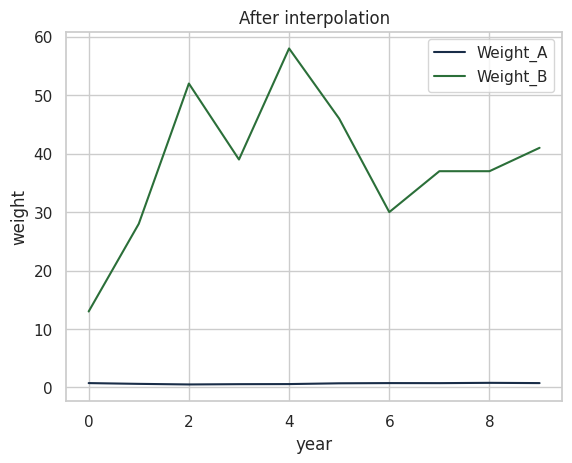

In [50]:
f1 = interp1d(nDF["gamma"], nDF['score'],kind='cubic')
f2 = interp1d(nDF["gamma"], nDF['fn'],kind='cubic')

xnew = np.arange(1.1,4,.3)
df2 = pd.DataFrame()
df2['Weight_A'] = f1(xnew)
df2['Weight_B'] = f2(xnew)
print(df2)
ax2 = df2.plot.line()
ax2.set_title('After interpolation')
ax2.set_xlabel("year") #???
ax2.set_ylabel("weight")


plt.show()

In [51]:
d = {"Logistic Regression":lrFNs,"Random Forest":rfFNs,"K Nearest Neighbor":knnFNs,"Multi-Layer Perceptron":mlpFNs,"Support Vector Classification":svmFNs,"gamma":gammas}
#n = np.array([lrFNs,rfFNs,knnFNs,mlpFNs,svmFNs])
mlstuffs = pd.DataFrame(d)

In [52]:
print(svmScores)

[0.496, 0.492, 0.508, 0.516, 0.44, 0.468, 0.536, 0.468, 0.464, 0.492, 0.524, 0.54, 0.52, 0.588, 0.556, 0.628, 0.608, 0.596, 0.624, 0.592, 0.636, 0.688, 0.732, 0.728, 0.764, 0.728, 0.732, 0.768, 0.732, 0.68]


In [53]:
s = {"Logistic Regression":lrScores,"Random Forest":rfScores,"K Nearest Neighbor":knnScores,"Multi-Layer Perceptron":mlpScores,"Support Vector Classification":svmScores,"gamma":gammas}
scoreStuffs = pd.DataFrame(s)

In [54]:
meltedScores = scoreStuffs.melt(id_vars=['gamma'])
meltedScores = scoreStuffs.melt(id_vars=['gamma'])
meltedScores.columns = ["gamma","Classification Model","Accuracy"]

In [55]:
meltedML = mlstuffs.melt(id_vars=['gamma'])
meltedML.columns = ["gamma","Classification Model","Number of False Negatives"]

In [56]:
# from google.colab import drive
# drive.mount('drive')

In [57]:
meltedScores.to_csv('meltedScores.csv')
meltedML.to_csv("meltedML.csv")
# !cp meltedScores.csv "drive/My Drive/Research"
# !cp meltedML.csv "drive/My Drive/Research"

In [58]:
meltedML.head()

,gamma,Classification Model,Number of False Negatives
0,1.1,Logistic Regression,75
1,1.2,Logistic Regression,80
2,1.3,Logistic Regression,74
3,1.4,Logistic Regression,70
4,1.5,Logistic Regression,78


<Axes: xlabel='Gamma', ylabel='Number of False Negatives'>

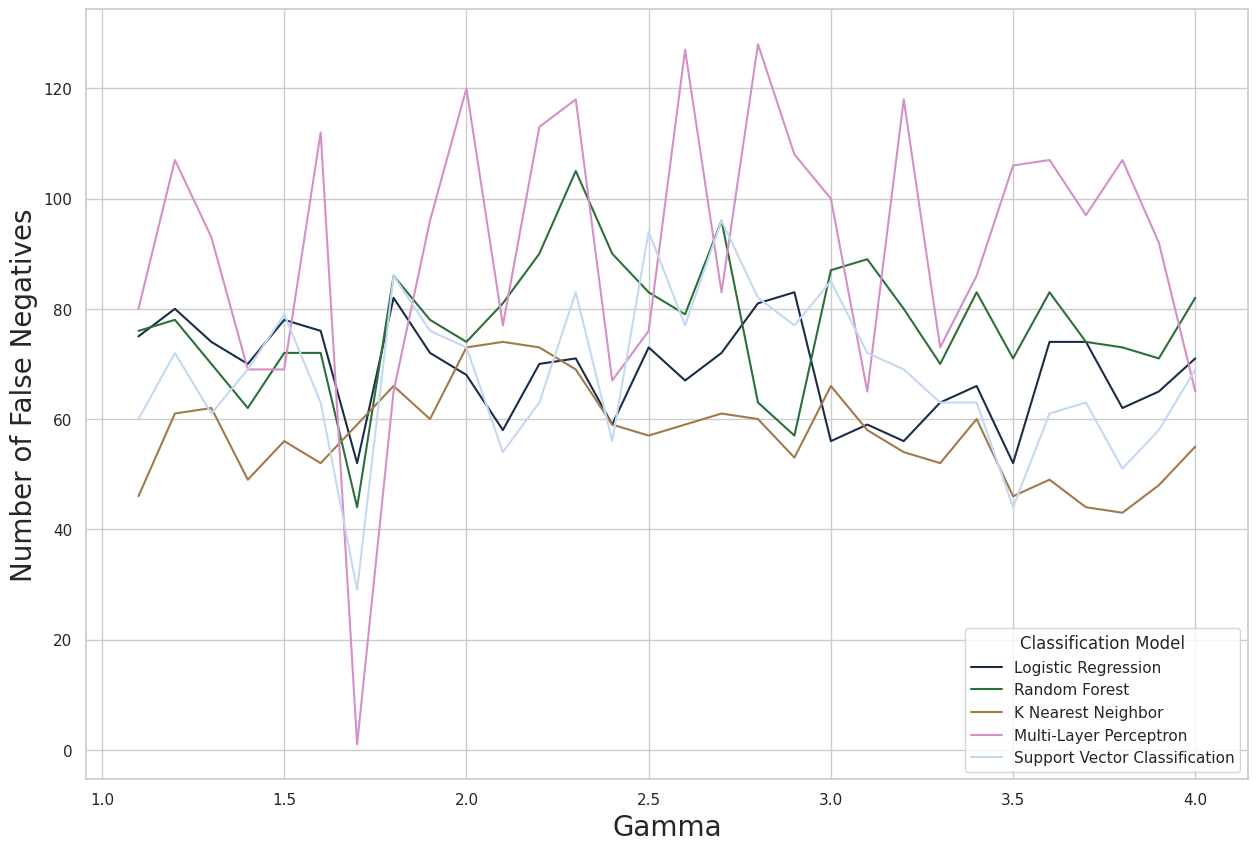

In [59]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Number of False Negatives',fontsize=20);
sns.lineplot(ax=ax,x="gamma",y="Number of False Negatives",hue="Classification Model",data=meltedML)
#this displays during trainig and testing "how many malicious messages made it through" at different gammas

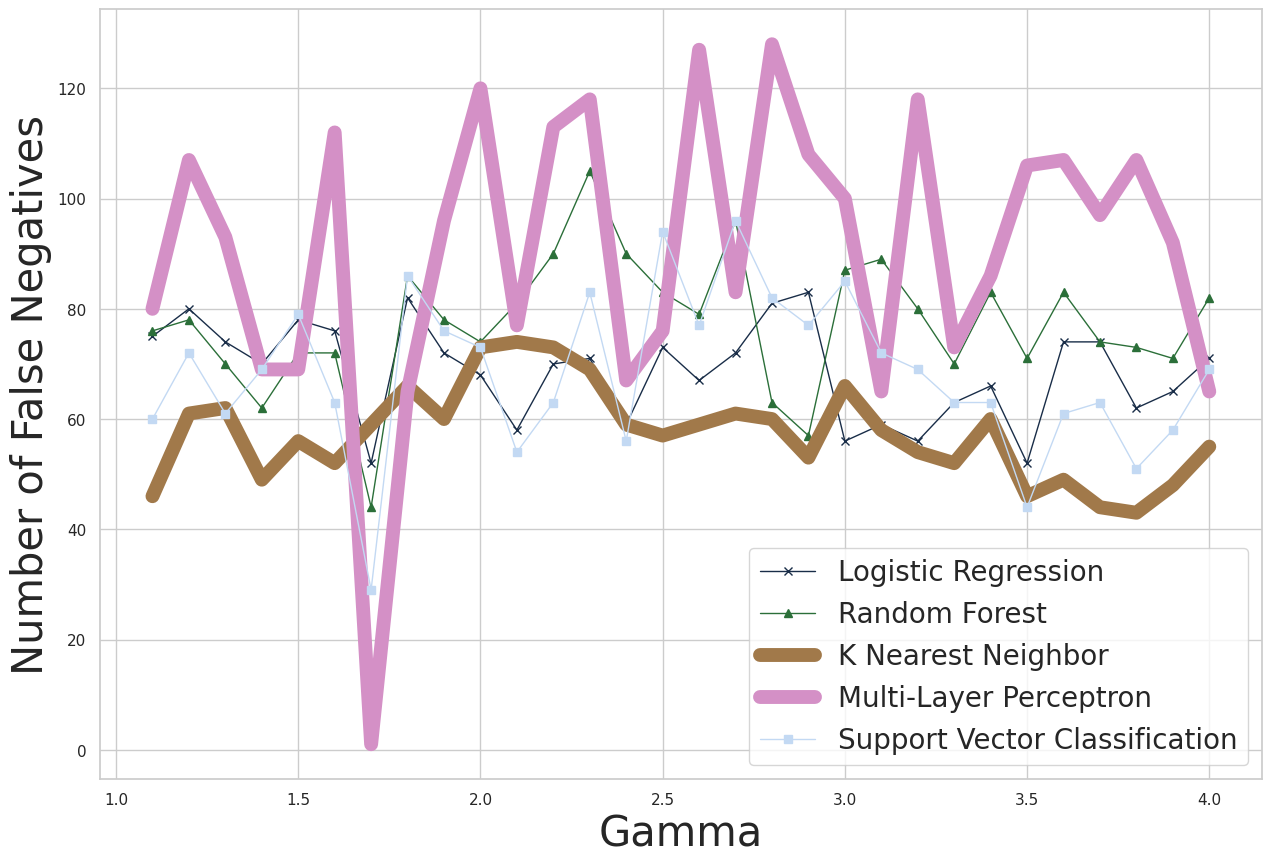

In [60]:
#plt.plot(meltedML[meltedML["Classification Model"] == "Logistic Regression"])
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=30);
ax.set_ylabel('Number of False Negatives',fontsize=30);
models = ["Logistic Regression","Random Forest","K Nearest Neighbor","Multi-Layer Perceptron","Support Vector Classification"]
markers = ["x","^","*","x","s"]
for i in range(len(models)):
  a = meltedML[meltedML["Classification Model"] == models[i]]
  if models[i] == "Multi-Layer Perceptron" or models[i] == "K Nearest Neighbor":
    plt.plot(a["gamma"],a["Number of False Negatives"],linewidth=10.0,marker=markers[i])
  else:
    plt.plot(a["gamma"],a["Number of False Negatives"],linewidth=1.0,marker=markers[i])
plt.legend(models,prop={'size': 20})

#lr = meltedML[meltedML["Classification Model"] == "Logistic Regression"]
#rf = meltedML[meltedML["Classification Model"] == "Random Forest"]

#plt.plot(lr["gamma"],lr["Number of False Negatives"])
#plt.plot(rf["gamma"],rf["Number of False Negatives"])


In [61]:
meltedScores.head()

,gamma,Classification Model,Accuracy
0,1.1,Logistic Regression,0.472
1,1.2,Logistic Regression,0.464
2,1.3,Logistic Regression,0.456
3,1.4,Logistic Regression,0.480
4,1.5,Logistic Regression,0.452


<Axes: xlabel='Gamma', ylabel='Accuracy'>

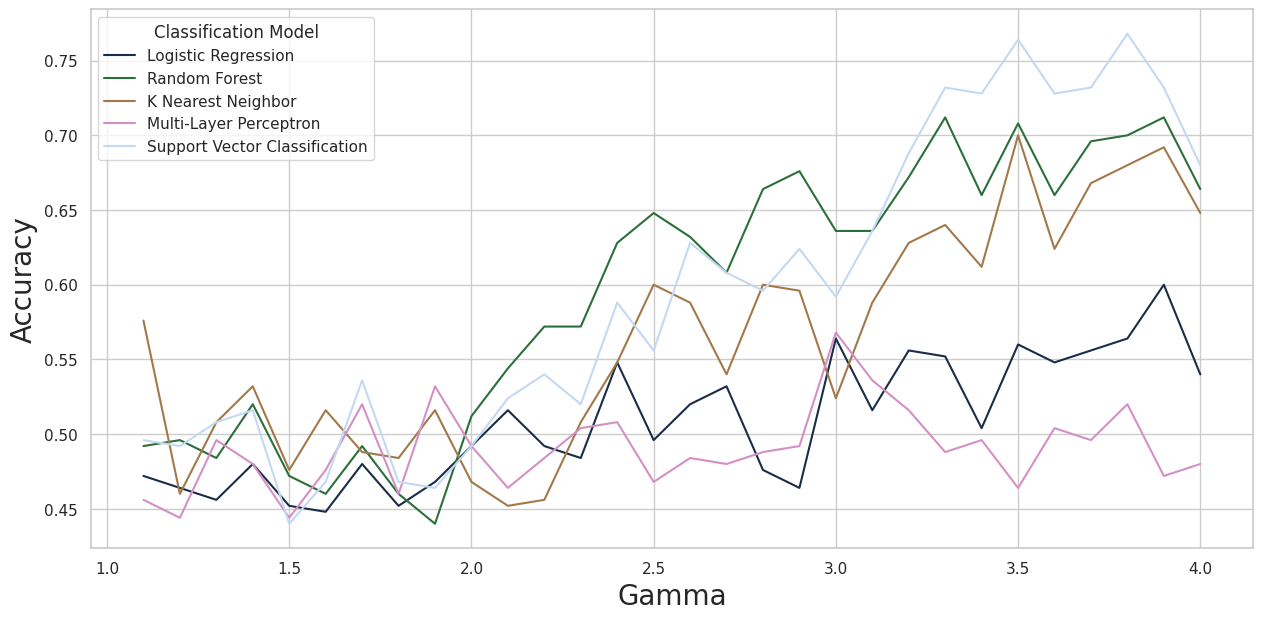

In [62]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
#ax.set(xlabel='Gamma', ylabel='False Negatives')
ax.set_xlabel('Gamma',fontsize=20);
ax.set_ylabel('Accuracy',fontsize=20);
sns.lineplot(ax=ax,x="gamma",y="Accuracy",hue="Classification Model",data=meltedScores)
#this displays during trainig and testing "how many malicious messages made it through" at different gammas

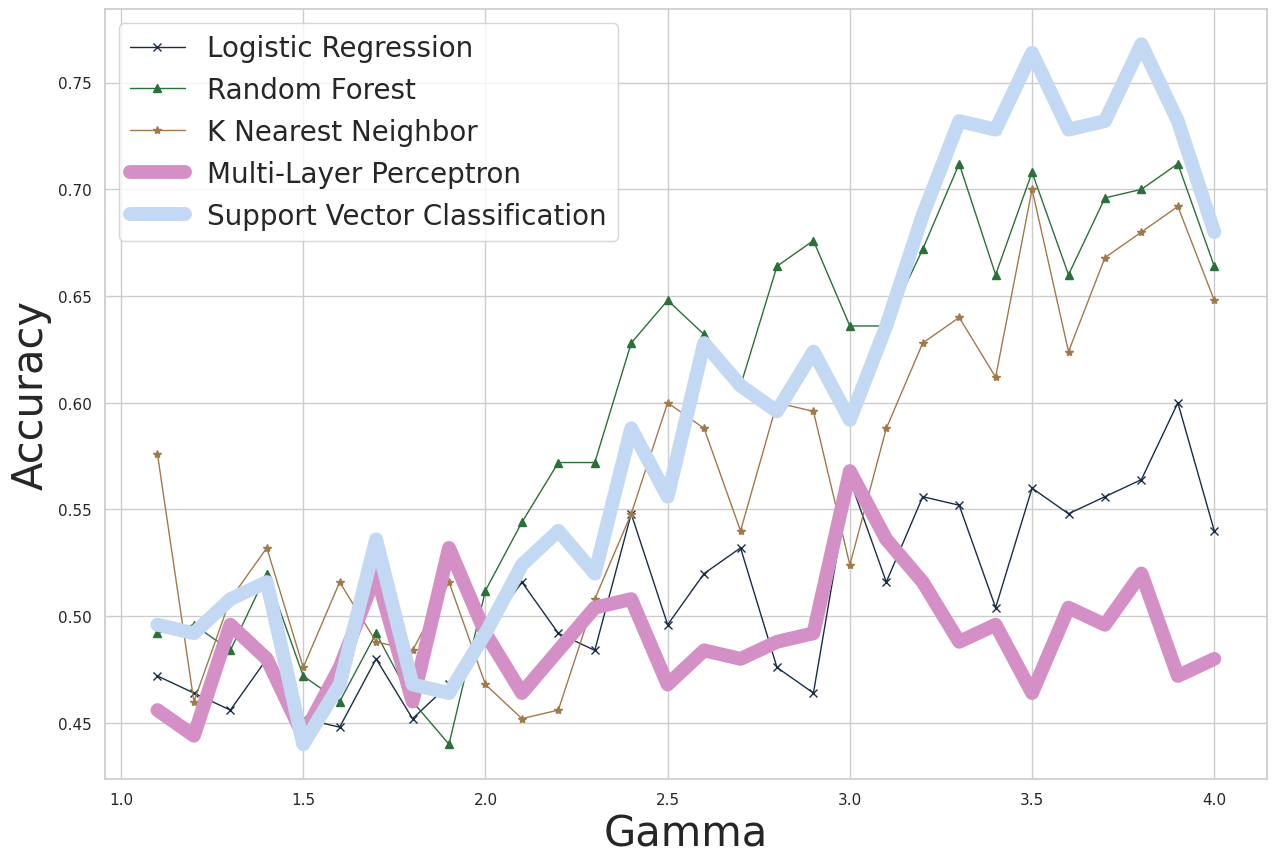

In [63]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_xlabel('Gamma',fontsize=30);
ax.set_ylabel('Accuracy',fontsize=30);
models = ["Logistic Regression","Random Forest","K Nearest Neighbor","Multi-Layer Perceptron","Support Vector Classification"]
markers = ["x","^","*","x","s"]
for i in range(len(models)):
  a = meltedScores[meltedScores["Classification Model"] == models[i]]
  if models[i] == "Multi-Layer Perceptron" or models[i] == "Support Vector Classification":
    plt.plot(a["gamma"],a["Accuracy"],linewidth=10.0,marker=markers[i])
  else:
    plt.plot(a["gamma"],a["Accuracy"],linewidth=1.0,marker=markers[i])
plt.legend(models,prop={'size': 20})

#lr = meltedML[meltedML["Classification Model"] == "Logistic Regression"]
#rf = meltedML[meltedML["Classification Model"] == "Random Forest"]

#plt.plot(lr["gamma"],lr["Number of False Negatives"])
#plt.plot(rf["gamma"],rf["Number of False Negatives"])


# Attempted Test

In [64]:
ogData = addLabel(makeSentence(df),0)

In [65]:
testData = pd.concat([ogData,malDF])

In [66]:
testData

,0,1
0,"40,cloudy,E,14",0
1,"51,partly cloudy,SE,95",0
2,"47,severe_thunderstorm,SE,88",0
3,"45,thunderstorm,W,35",0
4,"43,sunny,SE,33",0
...,...,...
49,"47,cloudy,SE,8",1
350,"44,thunderstorm,N,61",1
481,"45,severe_thunderstorm,W,54",1
333,"40,sunny,SE,7",1


In [67]:
testData[testData[1] == 1]

,0,1
76,"48,severe_thunderstorm,S,1",1
210,"58,rain,SE,6",1
235,"55,thunderstorm,N,21",1
346,"56,severe_thunderstorm,SE,14",1
139,"43,thunderstorm,NE,75",1
...,...,...
49,"47,cloudy,SE,8",1
350,"44,thunderstorm,N,61",1
481,"45,severe_thunderstorm,W,54",1
333,"40,sunny,SE,7",1


In [68]:
tokenized = testData[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [69]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [70]:
padded

array([[ 101, 2871, 1010, ...,    0,    0,    0],
       [ 101, 4868, 1010, ...,  102,    0,    0],
       [ 101, 4700, 1010, ..., 1010, 6070,  102],
       ...,
       [ 101, 3429, 1010, ..., 1010, 5139,  102],
       [ 101, 2871, 1010, ...,    0,    0,    0],
       [ 101, 3429, 1010, ..., 1010, 6391,  102]], shape=(866, 12))

In [71]:
train_features, test_features, train_labels, test_labels = train_test_split(padded, testData[1], random_state=42)

In [72]:
test_labels.value_counts()

1
0    127
1     90
Name: count, dtype: int64

### Logistic Regression Test

In [73]:
lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))
y_pred = lr_clf.predict(test_features)

0.5576036866359447


In [74]:
from sklearn.metrics import classification_report

# confusion_matrix(test_labels, y_pred)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.81      0.68       127
           1       0.43      0.20      0.27        90

    accuracy                           0.56       217
   macro avg       0.51      0.51      0.48       217
weighted avg       0.52      0.56      0.51       217



### Random Forest Test

In [75]:
RandForest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RandForest.fit(train_features, train_labels)
forest_pred = RandForest.predict(test_features)
print(RandForest.score(test_features,test_labels))

0.5714285714285714


In [76]:
confusion_matrix(test_labels, forest_pred)

array([[117,  10],
       [ 83,   7]])

### KNN

Accuracy 0.511520737327189
[[73 54]
 [52 38]]


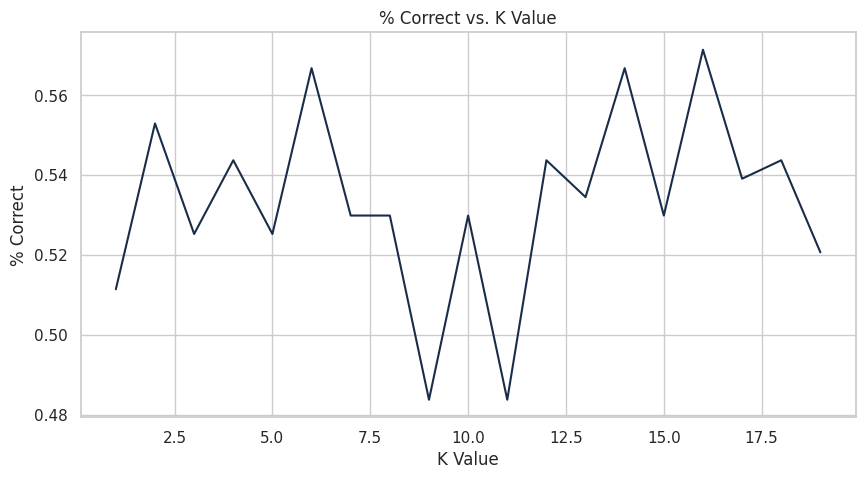

In [77]:
correct = []
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_features,train_labels)
    prediction = knn.predict(test_features)
    correct.append(np.mean(prediction == test_labels))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 20), correct)
plt.title('% Correct vs. K Value')
plt.xlabel('K Value')
plt.ylabel('% Correct')


#K Nearest Neighbor With Optimal Neighbor (1)
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(train_features,train_labels)
print("Accuracy " + str(knn.score(test_features, test_labels)))
y_pred = knn.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
#print(classification_report(y_test, y_pred))

### Neural Networks

In [78]:
NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
NeuralNetwork.fit(train_features, train_labels)
nn_pred = NeuralNetwork.predict(test_features)
print(NeuralNetwork.score(test_features,test_labels))
print(confusion_matrix(test_labels, nn_pred))

0.5668202764976958
[[123   4]
 [ 90   0]]


### SVC

In [79]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [80]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train_features,train_labels)

,steps,"[('standardscaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'auto'


In [81]:
pred = clf.predict(test_features)

In [82]:
# print(confusion_matrix(test_labels, pred))
print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

           0       0.60      0.86      0.71       127
           1       0.49      0.19      0.27        90

    accuracy                           0.58       217
   macro avg       0.54      0.52      0.49       217
weighted avg       0.55      0.58      0.53       217



### OCSVM